In [1]:
!pip install timm
!pip install opencv-python-headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
import cv2
import torch
import urllib.request
import matplotlib.pyplot as plt
import os

In [22]:
# Path to the input image
input_image_path = "/content/input/skull 2.jpg"  # Replace 'your_image.jpg' with the actual image name

model_type = "DPT_Large"  # Select model type: "DPT_Large", "DPT_Hybrid", "MiDaS_small"
midas = torch.hub.load("intel-isl/MiDaS", model_type)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type in ["DPT_Large", "DPT_Hybrid"]:
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [23]:
# Load and preprocess the image
img = cv2.imread(input_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

In [24]:
# Perform depth estimation
with torch.no_grad():
    prediction = midas(input_batch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


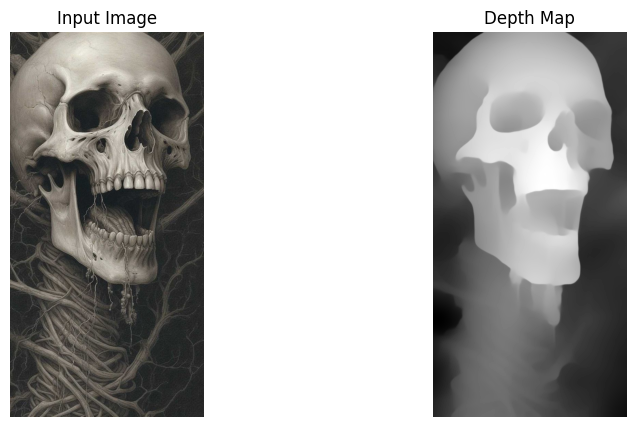

True

In [25]:
# Display the input image and the depth map in grayscale
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Depth Map")
plt.imshow(output, cmap='gray')
plt.axis('off')

plt.show()

# Generate the output file name based on the input file name
input_file_name = os.path.basename(input_image_path)
output_file_name = os.path.splitext(input_file_name)[0] + "_Depth_Map.jpg"
output_image_path = os.path.join("/content/output", output_file_name)  # Ensure this folder exists or create it

# Save the depth map
cv2.imwrite(output_image_path, (output * 255).astype("uint8"))